# Distributional and frequency effects in word embeddings: Frequency effects of vectors
## © 2018 Chris Culy, June 2018
### [chrisculy.net](http://chrisculy.net/)

## Overview
This is one of a [series of posts](dist_freq_intro.html). In this post I examine three aspects of word vectors to look for frequency effects: the vectors, the dimensions, and the nearest neighbors. The first and third aspects have been explored for other methods with a large corpus by [[1]](#ref1). The results here differ somewhat from those in [[1]](#ref1), but the relation between vectors and frequency holds up.

### Results and contributions

* Vectors encode varying amounts of information about frequency (cf [[1]](#ref1))
    - **new** ppmi encodes the most followed by sgns; ft and glove vary more
    - **new** the amount of information encoded varies by the corpus
    - **new** low frequency words encode very little frequency information, across methods
* **new** Individual dimensions encode relatively little information about frequency
* **new** The "power law" for nearest neighbors from [[1]](#ref1) is mostly _not_ reproduced with these methods and these smaller corpora


[Download as Jupyter notebook](dist_freq_vecs.ipynb)

[Download supplemental Python code](dfewe.zip)

<input type="checkbox" id="toggleCheck" checked> Show Code

In [1]:
#imports
from dfewe import *

#for tables in Jupyter
from IPython.display import HTML, display
import tabulate

In [2]:
# some utilities
def show_title(t):
    display(HTML('<b>%s</b>' % t))

def show_table(data,headers,title):
    show_title(title)
    display(HTML(tabulate.tabulate(data,tablefmt='html', headers=headers)))

In [3]:
#set up standard corpora + vectors
vfair_all = Setup.make_standard_sampler_and_vecs('vfair',5,100,1) #window=5, dims=100, min_count=1
heartd_all = Setup.make_standard_sampler_and_vecs('heartd',5,100,1) #window=5, dims=100, min_count=1

what = [['Vanity Fair (vfair)'],['Heart of Darkness (heartd)']]
for i,c in enumerate([vfair_all,heartd_all]):
    sampler = c['sampler']
    what[i].extend([sum(sampler.counts.values()), len(sampler.counts)])

show_table(what, headers=['Corpus','Tokens','Types'], title="Corpora sizes")

## Background

So far we have been looking at similarities and ranks, which involve 2 vectors at a time. Given that we have found frequency related effects, from [shifted similarity means](dist_freq_sim_shift.html) to [stratification of similarities and ranks](dist_freq_stratification.html), we should also ask whether there are frequency effects at the level of individual vectors, and even at the level of individual dimensions. [[1]](#ref1) found two types of vector-level frequency effects, which we will expand on here. We'll also look at whether there are frequency effects for dimensions. The results here differ somewhat from those in [[1]](#ref1), as I'll discuss below.


## Simple vector frequency effects

To see whether word vectors are related to the frequency of their associated words, [[1]](#ref1) constructed a logistic prediction task "to put words either in a frequent or rare category" based on the vectors, and they found that a variety of methods (Glove is the only one that overlaps with the methods here) all gave positive results. In other words, they found that word frequency is related to (or encoded in, in their terms) the word vectors.

The approach here is somewhat simpler: we simply try to fit a linear model from the vectors to the percentiles of the corresponding words. When we do that for _Vanity Fair_ (_vfair_) we get the following.


In [4]:
def show_vectors_vs_percentiles(combo,name,lower_percentile=0,upper_percentile=100):
    """
    Show results in table
    """
    what,nwords = VectorCalcs.vectors_vs_percentile(combo,lower_percentile=lower_percentile,upper_percentile=upper_percentile)
    show_table(what,['Method','R<sup>2</sup>'], 'Linear regression for %d vectors in percentiles %d to %d in %s' 
               % (nwords, lower_percentile, upper_percentile, name))

def compare_vectors_vs_percentiles(combo,name,ranges=[(0,100)]):
    """
    show a table with the R^2 values for the different ranges for each method in combo 
    """
    
    """
    range, nwords, methods...
    """
    
    
    what = []
    for lowerp,upperp in ranges:
        results,nwords = VectorCalcs.vectors_vs_percentile(combo,lower_percentile=lowerp,upper_percentile=upperp)
        what.append(['%d - %d' % (lowerp,upperp),nwords] + [r[1] for r in results])
     
    headers = ['Percentile range','Vocab','sgns','ft','glove','ppmi']
    show_table(what,headers,'Linear regression R<sup>2</sup> for %s' % name)

In [5]:
compare_vectors_vs_percentiles(vfair_all,'vfair')

What we see is a bit different from the findings in [[1]](#ref1) which is based on a much larger Wikipedia corpus with a vocabulary vocabulary size of 103,000+ as opposed to the 15,000+ of vfair. In particular, sgns and ppmi do suggest a relation between a vector and the relative frequency of its word, but ft and especially glove are much weaker. 

Since we have seen that very low frequency words have disproportionate effect on similarties and ranks, we can probe a bit further by removing low freqency words and fitting the model to the remainder. Similarly, we can remove very high frequency words, or both.

In [6]:
compare_vectors_vs_percentiles(vfair_all,'vfair',[(0,100),(1,100),(5,100),(0,99),(0,95),(1,99),(5,95)])

We find that removing the very low frequency words increases the $R^{2}$ across the board, quite dramatically for glove, such that all four methods seem to have a relation between vectors and relative frequency. In other words, most of the vocabulary (the low frequency items) does **not** encode (very much) information about frequency, but the remaining portion does, to varying degrees by method.

While it isn't clear from [[1]](#ref1) whether very low frequency words were omitted their tests, if they were that could explain the difference in results for glove. We can note that very high frequency words (<1% of the vocabulary) have negligible effect on the results.

Repeating the tests for _Heart of Darkness_ (_heartd_), we find that the results are _much weaker, except for ppmi_ which has an even higher $R^{2}$ than for vfair. This suggests that the size of the corpus is a contributing factor in how much frequency information is encoded in the vectors, whether more for ppmi or less for the others. On the other hand, we do see the same pattern as in vfair, where the very low frequency words do not encode very much frequency information.

In [7]:
compare_vectors_vs_percentiles(heartd_all,'heartd',[(0,100),(1,100),(5,100),(0,99),(0,95),(1,99),(5,95)])

Given that vectors seem to encode some frequency information, at least in some cases, we might wonder whether individual dimensions also encode frequency information. The answer for vfair and heartd is mostly negative. In the tables below, I've filtered the 100 dimensions to show only those where _one_ of the methods has an $R^{2}$ above a certain threshold. 

What we see is that the $R^{2}$ for a single dimension never gets above 0.45 for vfair (and 0.4 for heartd), even suppressing the low frequency words. There are other finer grained patterns that are puzzling, but since the overall results are weak, they are probably not worth pursuing, and I won't do so here.

In [8]:
def show_dimensions_vs_percentiles(combo,name,lower_percentile=0,upper_percentile=100, thresh=0.25):
    """
    Show table of R^2 for each dimension and each method for the words in percentile range
    Show only rows where at least one R^2 is above the threshold
    """
    d,nwords = VectorCalcs.compare_dimensions_vs_percentiles(combo,lower_percentile=lower_percentile,upper_percentile=upper_percentile)
    
    npd = np.array(d)
    mask = (npd[:, 1] > thresh) | (npd[:, 2] > thresh) | (npd[:,3] > thresh) | (npd[:,4] > thresh)
    d = list(npd[mask])
    
    headers = ['Dimension','sgns','ft','glove','ppmi']
    title = 'Linear regression R<sup>2</sup> for each dimension in %s, %d words in range %d - %d. Threshold for one dimension is %0.3f' % (name,nwords,lower_percentile, upper_percentile, thresh)
    
    show_table(d,headers,title)

In [9]:
show_dimensions_vs_percentiles(vfair_all,'vfair', thresh=0.3)

show_dimensions_vs_percentiles(vfair_all,'vfair',lower_percentile=5,upper_percentile=100,thresh=0.3)

show_dimensions_vs_percentiles(heartd_all,'heartd',thresh=0.1)

show_dimensions_vs_percentiles(heartd_all,'heartd',lower_percentile=5,upper_percentile=100,thresh=0.1)

## Frequency effect in nearest neighbors

[[1]](#ref1) also look at the k-nearest neighbors of word (from a small subset used in one word similarity evaluation), and find a power-law relation between a word's frequency rank and it's nearest neighbor rank:

<blockquote>
For each of the words in the WordSim-353 dataset, we queried for the k = 1000 nearest neighbors. We then looked up their frequency ranks in the training corpus and averaged those ranks over all the query words. We found a strong correlation between the frequency of a word and its position in the ranking of nearest neighbors in our experiments. Figure 4 shows a power law relationship for C&amp;W embeddings between a word’s nearest neighbor rank (w.r.t. a query) and the word’s frequency rank in the training corpus ($nn-rank ∼ 1000 · corpus-rank^{0.17}$).
</blockquote>

Since our corpora are small, we can do the same calculations on the whole vocabulary. When we do that for these small corpora, the results are mixed. First vfair. In the charts below, I show both simple scales and log-log scales, and fit linear models to both &mdash; in the latter case that would give us a power law. Once again the results are mixed at best, with only sgns showing a fairly strong power-law relation. ppmi on the other hand is all over the place.

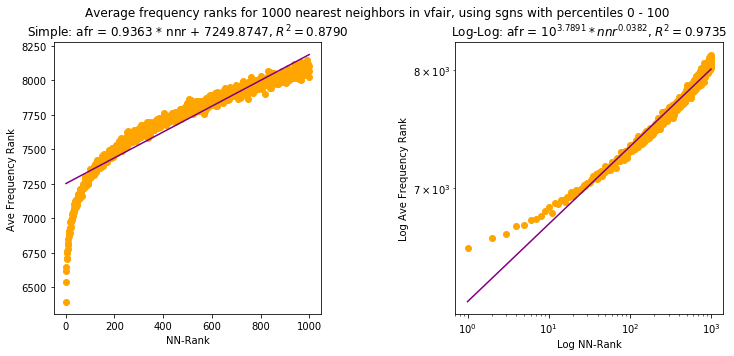

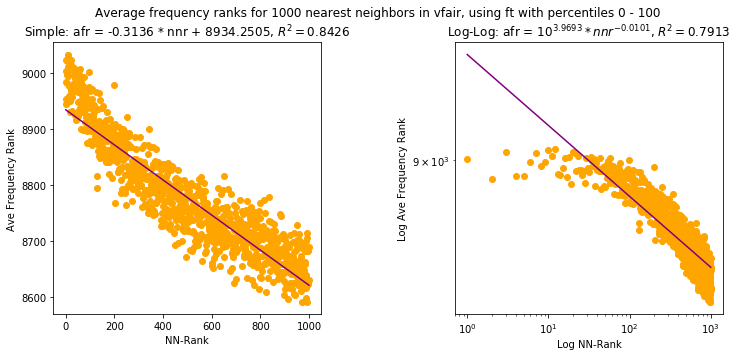

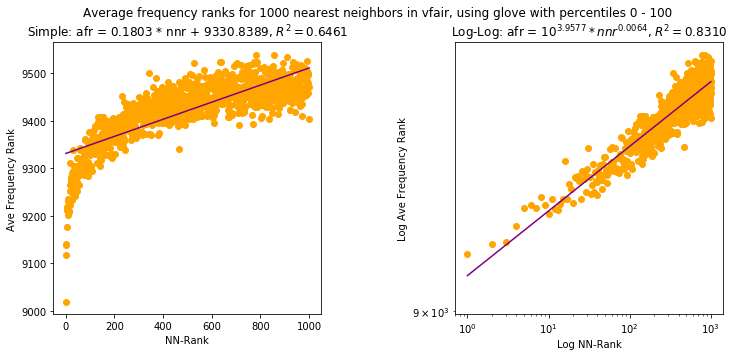

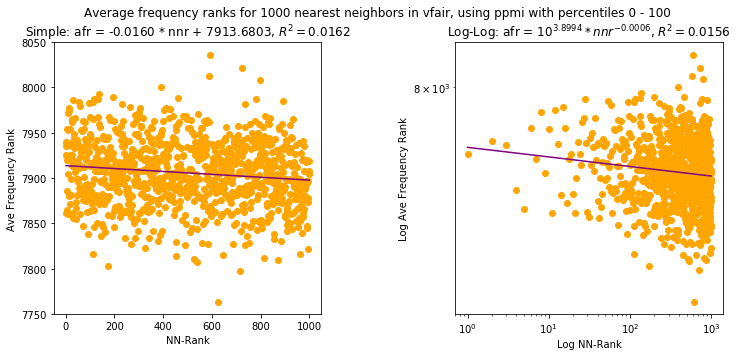

In [10]:
VectorCalcs.compare_ave_nn_ranks(vfair_all,'vfair')

Trying the same experiment with heartd, the results aren't even mixed. The best result is a simple linear relation, not a power law relation, but also with sgns as with vfair.

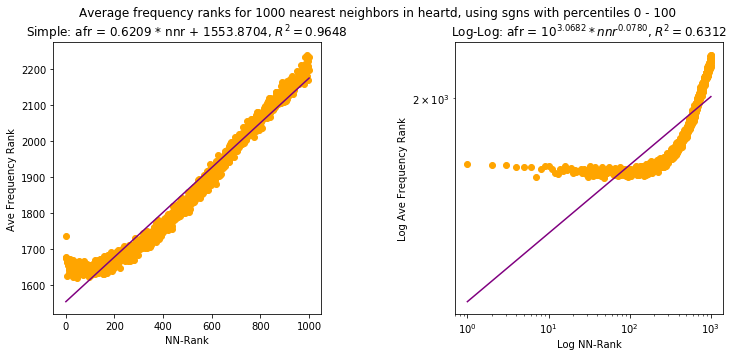

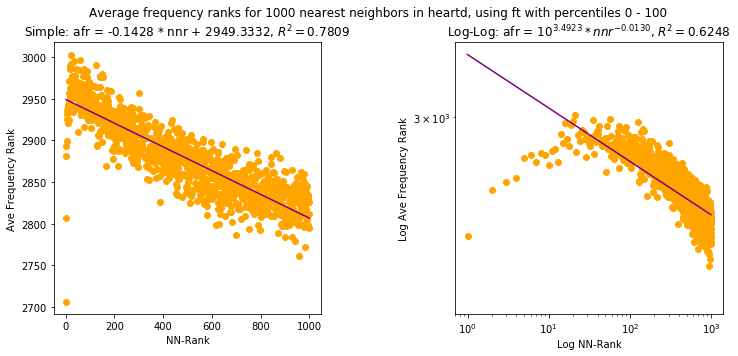

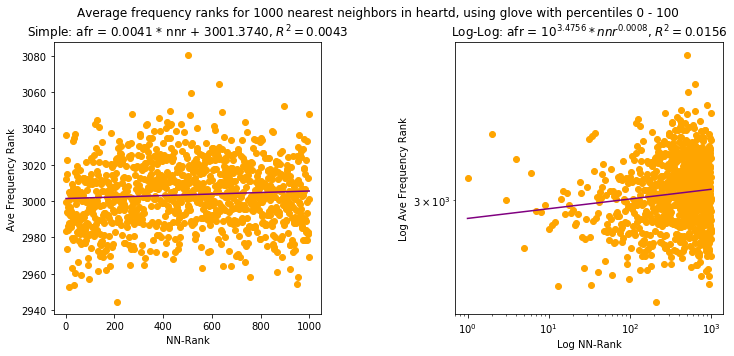

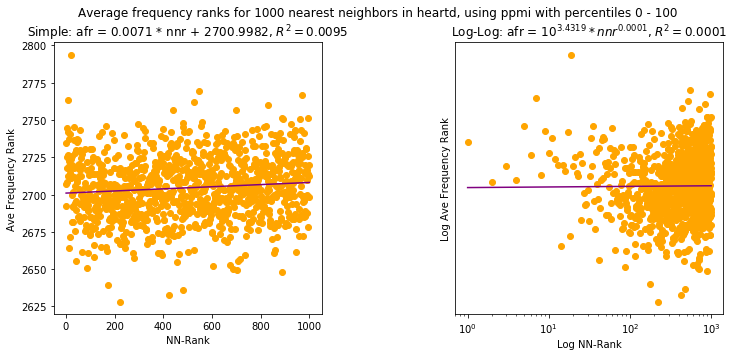

In [11]:
VectorCalcs.compare_ave_nn_ranks(heartd_all,'heartd')

We can try removing the very low frequency words, as we've done before. vfair shows (roughly) linear relations for sgns and glove, and that's about it; heartd also shows a roughly linear relation for sgns, but nothing else.

In short, the nearest neighbor results from [[1]](#ref1) are mostly not reproduced here, with much smaller corpora and different methods. While it might be worth exploring this approach further, it does not seem like it is shows an inherent property either of language or of the word embedding methods.

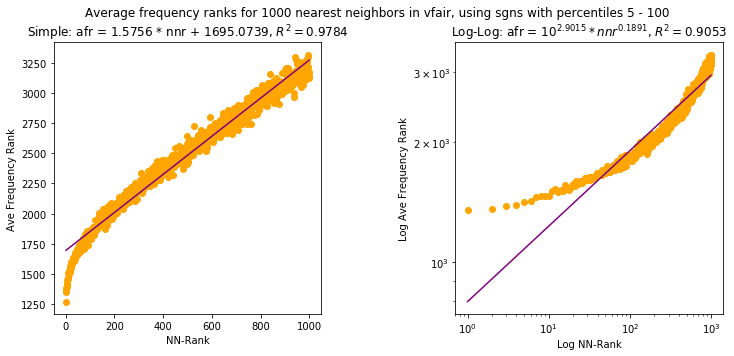

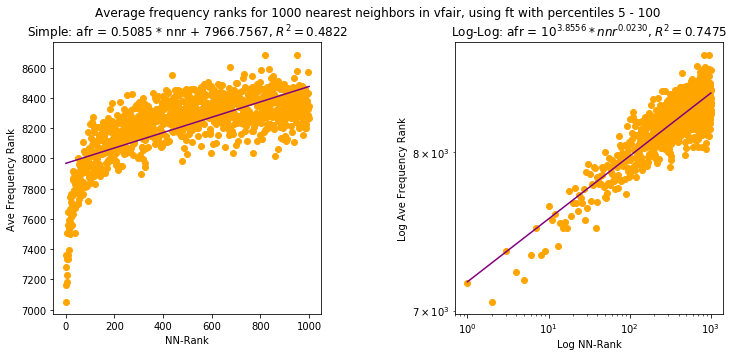

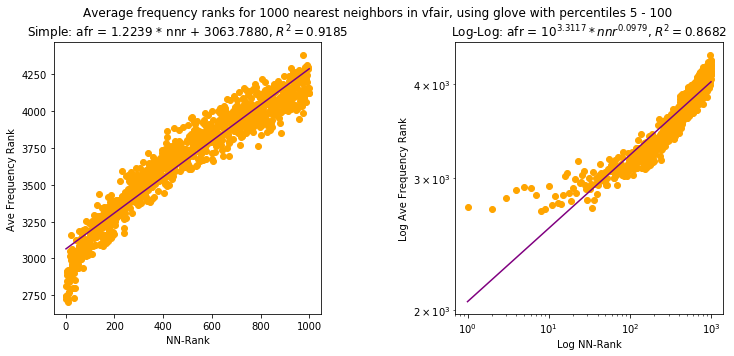

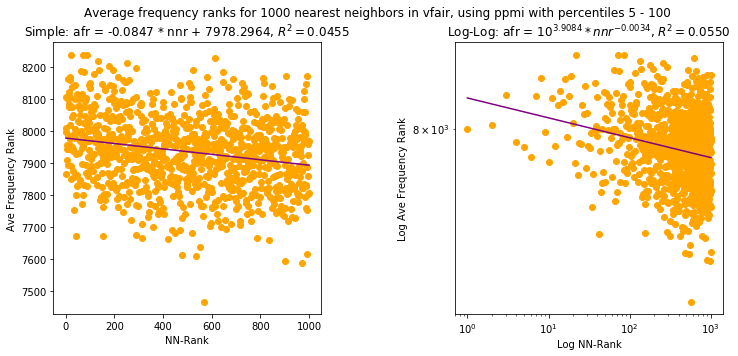

In [12]:
VectorCalcs.compare_ave_nn_ranks(vfair_all,'vfair', lower_percentile=5, upper_percentile=100)

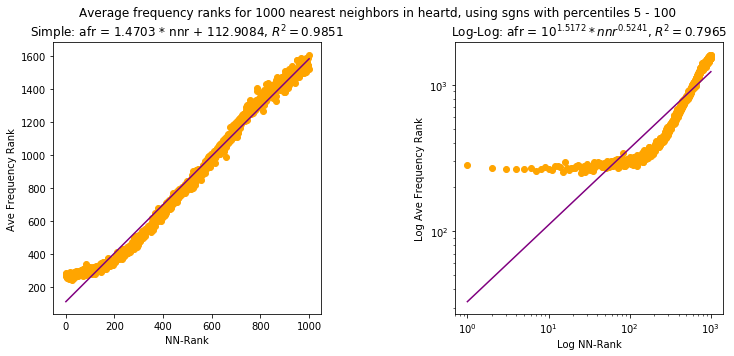

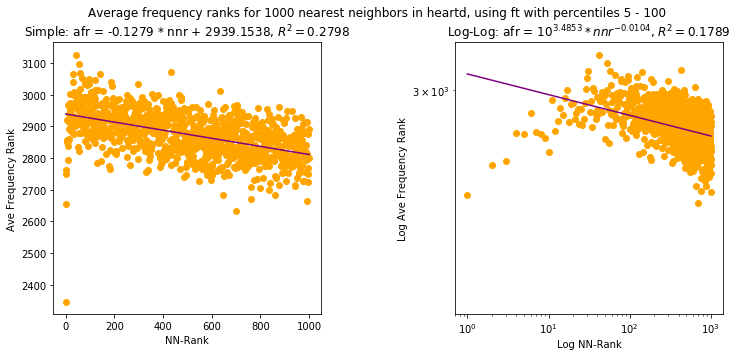

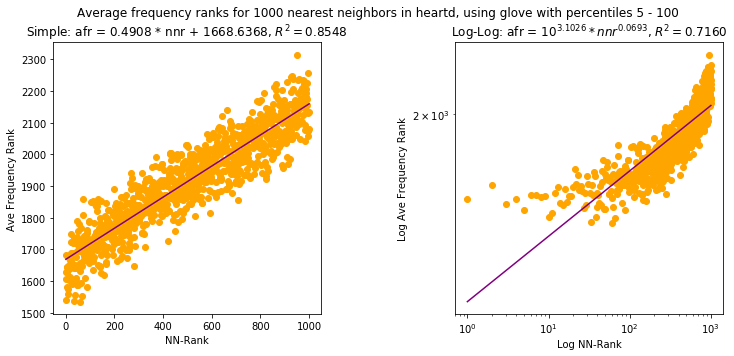

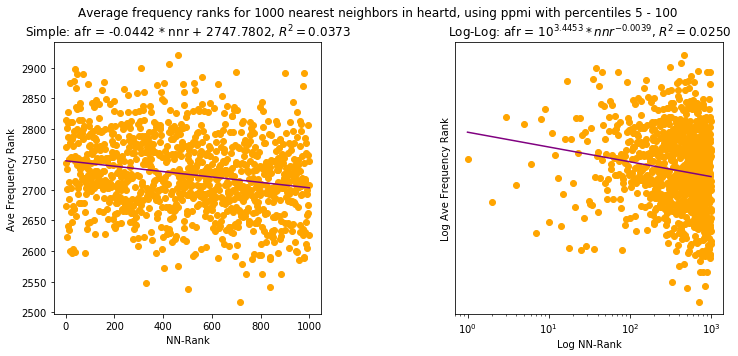

In [13]:
VectorCalcs.compare_ave_nn_ranks(heartd_all,'heartd', lower_percentile=5, upper_percentile=100)

[[2]](#ref2) discuss another aspect of frequency and nearest neighbors. They find that the reliablity of vectors is related to their frequency, where by reliability they mean having the same nearest neighbors across different runs of an algorithm with the same parameters on the same corpus. In the first set of posts I discussed the issue of reliability (or stability as I called it), and [proposed a method](wvecs_random_fix.html) for achieving stability.


## Summary 

In this post I've looked at three potential aspects of frequency effects with word vectors: the vectors, dimensions, and nearest neighbors. However, only the vectors themselves show robust frequency effects, and then primarily with non-low frequency words.

To repeat the findings listed at the beginning:

* Vectors encode varying amounts of information about frequency (cf [[1]](#ref1))
    - **new** ppmi encodes the most followed by sgns; ft and glove vary more
    - **new** the amount of information encoded varies by the corpus
    - **new** low frequency words encode very little frequency information, across methods
* new> Individual dimensions encode relatively little information about frequency
* new> The "power law" for nearest neighbors from [[1]](#ref1) is mostly not reproduced with these methods and these smaller corpora


[Back to the introduction](dist_freq_intro.html)


## The posts

* [Shifted similarity distributions](dist_freq_sim_shift.html)
* [Similarity stratification](dist_freq_stratification.html)
* ➤ Frequency effects of vectors
* [Strange geometry](dist_freq_geometry.html)
* [Distributional effects and hubs](dist_freq_hubs.html)
* [Recapitulation and next steps](dist_freq_recapit.html)

## References

<span id="ref1">[1]</span> Tobias Schnabel, Igor Labutov, David Mimno, and Thorsten Joachims. 2015. Proceedings of the 2015 Conference on Empirical Methods in Natural Language Processing.

<span id="ref2">[2]</span> Johannes Hellrich and Udo Hahn. 2016. Bad Company—Neighborhoods in Neural Embedding Spaces Considered Harmful. In Proceedings of COLING 2016, the 26th International Conference on Computational Linguistics: Technical Papers, pp. 2785–2796, Osaka, Japan, December 11-17 2016.
